In [ ]:
import sys
!{sys.executable} -m pip install uv==0.6.14
!{sys.executable} -m uv pip sync ../requirements.txt

# Imports

In [2]:
import os

os.environ["BAYBE_TELEMETRY_ENABLED"] = "false"

import pandas as pd
import numpy as np
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

from botorch.exceptions import InputDataWarning
from linear_operator.utils.warnings import NumericalWarning
import warnings

warnings.simplefilter("ignore", (InputDataWarning, NumericalWarning))

from baybe import Campaign
from baybe.parameters import (
    CategoricalParameter,
    NumericalDiscreteParameter,
    SubstanceParameter,
)
from baybe.recommenders import RandomRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from utils import backtest_plot

from baybe.surrogates.gaussian_process.presets.edbo import EDBOKernelFactory
from baybe.recommenders import TwoPhaseMetaRecommender, BotorchRecommender
from baybe.surrogates import GaussianProcessSurrogate

recommender = TwoPhaseMetaRecommender(
    recommender=BotorchRecommender(
        surrogate_model=GaussianProcessSurrogate(
            kernel_or_factory=EDBOKernelFactory()
        )  # recommended for chemical problems
    )
)

import baybe

print(baybe.__version__)

0.12.2


# Settings

In [3]:
from direct_arylation import substances, concentrations, temperatures, lookup
from baybe.utils.random import set_random_seed

N_DOE_ITERATIONS = 40
BATCH_SIZE = 1
N_MC_ITERATIONS = 100
set_random_seed(1337)

# BayBE Setup

In [4]:
lookup.head()

,Concentration,Temp_C,Base,Ligand,Solvent,yield
0,0.1,105,Potassium acetate,BrettPhos,DMAc,5.47
1,0.1,105,Potassium acetate,Di-tert-butylphenylphosphine,DMAc,0.00
2,0.1,105,Potassium acetate,(t-Bu)PhCPhos,DMAc,78.95
3,0.1,105,Potassium acetate,Tricyclohexylphosphine,DMAc,7.26
4,0.1,105,Potassium acetate,PPh3,DMAc,28.15


In [5]:
objective = NumericalTarget(name="yield", mode="MAX").to_objective()

substance_encodings = ["MORDRED", "ECFP", "RDKIT2DDESCRIPTORS"]
scenarios = {
    encoding: Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=substances["solvents"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Base", data=substances["bases"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Ligand", data=substances["ligands"], encoding=encoding
                ),
                NumericalDiscreteParameter(name="Temp_C", values=temperatures),
                NumericalDiscreteParameter(name="Concentration", values=concentrations),
            ]
        ),
        objective=objective,
        recommender=recommender,
    )
    for encoding in substance_encodings
}

In [6]:
parameters = [
    CategoricalParameter(
        name="Solvent", values=substances["solvents"].keys(), encoding="OHE"
    ),
    CategoricalParameter(
        name="Base", values=substances["bases"].keys(), encoding="OHE"
    ),
    CategoricalParameter(
        name="Ligand", values=substances["ligands"].keys(), encoding="OHE"
    ),
    NumericalDiscreteParameter(name="Temp_C", values=temperatures),
    NumericalDiscreteParameter(name="Concentration", values=concentrations),
]

campaign_ohe = Campaign(
    searchspace=SearchSpace.from_product(parameters=parameters),
    objective=objective,
    recommender=recommender,
)

campaign_rand = Campaign(
    searchspace=SearchSpace.from_product(parameters=parameters),
    recommender=RandomRecommender(),
    objective=objective,
)

scenarios.update({"OHE": campaign_ohe, "Random Baseline": campaign_rand})

# Backtest with BayBE

In [7]:
results_baybe = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

results_baybe.rename(
    columns={
        "Scenario": "Substance encoding",
        "Num_Experiments": "Number of experiments",
        "yield_CumBest": "Running best yield",
    },
    inplace=True,
)


100%|######################################################################################################################################################################################################################################| 500/500 [22:22<00:00,  2.69s/it]


# Backtest with Optuna

In [8]:
def objective(trial):
    solvent = trial.suggest_categorical("Solvent", substances["solvents"].keys())
    base = trial.suggest_categorical("Bases", substances["bases"].keys())
    ligand = trial.suggest_categorical("Ligands", substances["ligands"].keys())
    temperature = trial.suggest_categorical("Temp_C", temperatures)
    concentration = trial.suggest_categorical("Concentration", concentrations)

    return lookup.loc[
        (lookup["Solvent"] == solvent)
        & (lookup["Base"] == base)
        & (lookup["Ligand"] == ligand)
        & (lookup["Temp_C"] == temperature)
        & (lookup["Concentration"] == concentration),
        "yield",
    ].values[0]


results_optuna = []
for k_mc in range(N_MC_ITERATIONS):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_DOE_ITERATIONS)
    values = [t.values[0] for t in study.trials]

    for k, itm in enumerate(values):
        results_optuna.append(
            {
                "Substance encoding": "Optuna",
                "Number of experiments": k + 1,
                "Iteration": k,
                "Running best yield": np.amax(values[: k + 1]),
                "Monte_Carlo_Run": k_mc,
                "yield_Measurements": itm,
                "yield_IterBest": itm,
            }
        )

results_optuna = pd.DataFrame(results_optuna)

# Store Results

In [9]:
results = pd.concat([results_baybe, results_optuna], ignore_index=True)
results

,Substance encoding,Monte_Carlo_Run,Iteration,Number of experiments,yield_Measurements,yield_IterBest,Running best yield
0,MORDRED,0,0,1,[0.0],0.00,0.00
1,MORDRED,0,1,2,[16.95],16.95,16.95
2,MORDRED,0,2,3,[40.04],40.04,40.04
3,MORDRED,0,3,4,[52.2],52.20,52.20
4,MORDRED,0,4,5,[26.56],26.56,52.20
...,...,...,...,...,...,...,...
23995,Optuna,99,35,36,18.26,18.26,99.81
23996,Optuna,99,36,37,0.74,0.74,99.81
23997,Optuna,99,37,38,86.14,86.14,99.81
23998,Optuna,99,38,39,0.83,0.83,99.81


In [10]:
results.to_csv("../results/chemical_encodings.csv", index=None)

# Load Result

In [11]:
results = pd.read_csv("../results/chemical_encodings.csv")

# Visualization

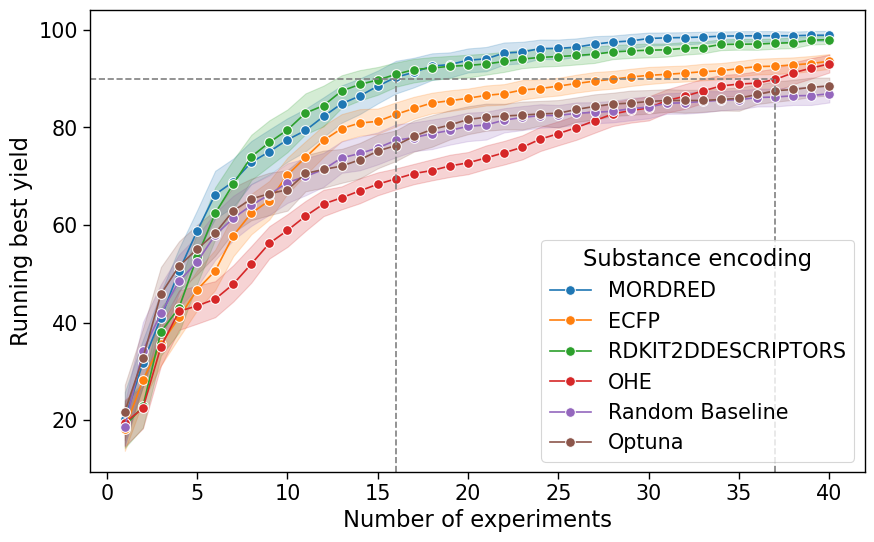

In [12]:
backtest_plot(
    df=results,
    figure_name="chemical_encodings",
    x="Number of experiments",
    y="Running best yield",
    hue="Substance encoding",
    indicator_y=90,
    indicator_labels=["MORDRED", "OHE"],
)